# Compare models using Chen2020 parameters
This gives a quick example showing how to compare two models during a constant current discharge followed by a rest phase, and uses the parameters defined in the file `Chen2020_params.py`.

We begin by importing pybamm and our parameter values stored in `Chen2020_params.py`

In [1]:
import pybamm

from Chen2020_params import parameter_values

We then make a list of the models we want to compare. We use the TSPMe from "Systematic derivation and validation of a reduced thermal-electrochemical model for lithium-ion batteries using asymptotic methods.", Ferran Brosa Planella, Muhammad Sheikh, and W. Dhammika Widanage, Electrochimica Acta, 2021, and the DFN with a lumped thermal model.

In [2]:
models = [
    pybamm.lithium_ion.SPMe(
        options={
            "thermal": "lumped",
            "dimensionality": 0,
            "cell geometry": "arbitrary",
            "electrolyte conductivity": "integrated",
        },
        name="TSPMe",
    ),
    pybamm.lithium_ion.DFN(
        options={
            "thermal": "lumped",
            "dimensionality": 0,
            "cell geometry": "arbitrary",
        },
        name="TDFN",
    ),
]


Next we define the experiment we want to run using a simple text-based syntax

In [3]:
experiment = pybamm.Experiment(
    [
        "Discharge at 2C until 2.5 V (5 second period)",
        "Rest for 1 hour (30 second period)",
    ],
)

We then loop of the models to solve, storing the solutions in a list. We also print the solve times.

In [4]:
sols = []
for model in models:
    sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment)
    sol = sim.solve()
    print(model.name, "solve time:", sol.solve_time)
    sols.append(sol)

TSPMe solve time: 149.212 ms
TDFN solve time: 9.298 s


We can create a quick plot to see how the solutions compare

In [5]:
vars_to_plot = [
        "Negative particle surface concentration [mol.m-3]",
        "Positive particle surface concentration [mol.m-3]",
        "Electrolyte concentration [mol.m-3]",
        "Current [A]",
        "Negative electrode potential [V]",
        "Positive electrode potential [V]",
        "Terminal voltage [V]",
        "Volume-averaged cell temperature [K]",
]
pybamm.dynamic_plot(sols, vars_to_plot)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.4777385072723446, step=0.01477738507272344…

Or create a custom plot showing the error in the TSPMe vs the DFN. We could also load in some experimental data to compare against for accuracy. 

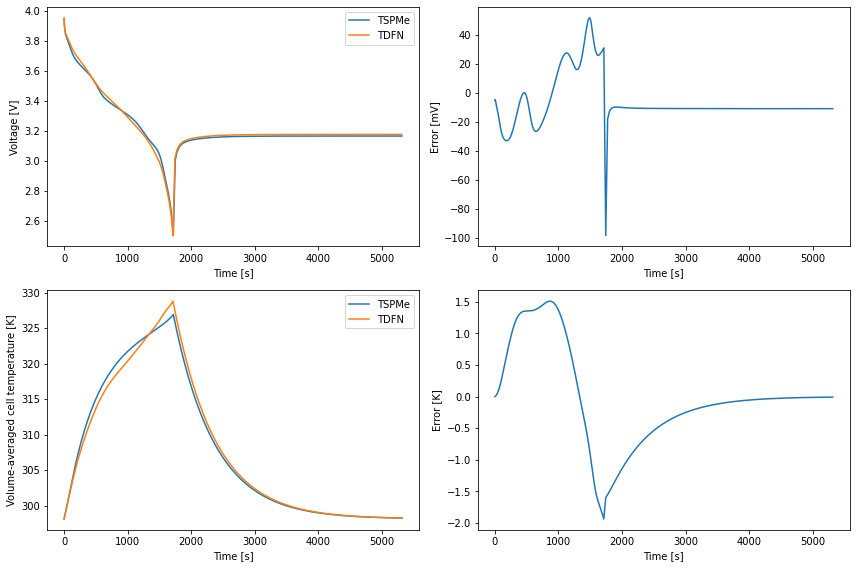

In [6]:
import matplotlib.pyplot as plt
import numpy as np 

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# plot voltage and temperature for each model
for i, sol in enumerate(sols):
    ax[0, 0].plot(sol["Time [s]"].entries, sol["Terminal voltage [V]"].entries, label=models[i].name)
    ax[1, 0].plot(sol["Time [s]"].entries, sol["Volume-averaged cell temperature [K]"].entries, label=models[i].name)
ax[0, 0].set_xlabel("Time [s]")
ax[0, 0].set_ylabel("Voltage [V]")
ax[0, 0].legend()
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel("Volume-averaged cell temperature [K]")
ax[1, 0].legend()

# plot error between TSPMe and DFN
V_diff = (
    sols[0]["Terminal voltage [V]"](sols[1]["Time [s]"].entries) 
    - sols[1]["Terminal voltage [V]"](sols[1]["Time [s]"].entries)
)  # voltage difference in V
ax[0, 1].plot(sols[1]["Time [s]"].entries, V_diff * 1000) # plot in mV
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Error [mV]") 
T_diff = (
    sols[0]["Volume-averaged cell temperature [K]"](sols[1]["Time [s]"].entries) 
    - sols[1]["Volume-averaged cell temperature [K]"](sols[1]["Time [s]"].entries)
)  # temperature differene in K
ax[1, 1].plot(sols[1]["Time [s]"].entries, T_diff)
ax[1, 1].set_xlabel("Time [s]")
ax[1, 1].set_ylabel("Error [K]")   

plt.tight_layout()